In [12]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

#nltk.download('all')
import nltk 
from nltk.corpus import stopwords, wordnet 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [2]:
import regex as re

In [3]:
class PreprocessTweets:
    def __init__ (self, text):
        self.text = text
        
    def normalize_letters(self):
        self.text = re.sub("[إأآا]", "ا", self.text)
        self.text = re.sub("ى", "ي", self.text)
        self.text = re.sub("ؤ", "ء", self.text)
        self.text = re.sub("ئ", "ء", self.text)
        self.text = re.sub("ة", "ه", self.text)
        self.text = re.sub("گ", "ك", self.text)
        self.text =  re.sub(r'(.)\1+', r'\1', self.text)
        
    def remove_tashkeel(self):
        tashkeel = re.compile("""
                                                     ّ    | # Tashdid
                                                     َ    | # Fatha
                                                     ً    | # Tanwin Fath
                                                     ُ    | # Damma
                                                     ٌ    | # Tanwin Damm
                                                     ِ    | # Kasra
                                                     ٍ    | # Tanwin Kasr
                                                     ْ    | # Sukun
                                                     ـ     # Tatwil/Kashida
                                                 """, re.VERBOSE)
        self.text = re.sub(tashkeel, '', self.text)
        
    def sub_chars(self):
        chlist = [chr(i) for i in range(1569, 1611)] + [chr(i) for i in range(1646, 1749)]
        self.text = ''.join([i if i in chlist else ' ' for i in self.text])
        self.text = ' '.join([u'{}'.format(i) for i in self.text.split() if len(i) > 1])
        self.text = re.sub(r'\d+', ' ', self.text)
    
    def remove_symbols_spaces_and_english(self):
        symbols1 = re.compile('[/(){}\[\]\|,;]')
        symbols2 = re.compile("[@|(|)|\||:|>|<|_|#|\.|+|÷|×|'|!|\?|٪|؟\|&|;|\*|[|]|{|}|-|،|_|’|;|!|:|^|&|%|/]")
        arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
        
        emojies = re.compile("["
                            u"\U0001F600-\U0001F64F" 
                            u"\U0001F300-\U0001F5FF"  
                            u"\U0001F680-\U0001F6FF" 
                            u"\U0001F1E0-\U0001F1FF"  
                            u"\U00002500-\U00002BEF"  
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642" 
                            u"\u0640"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                            "]+", re.UNICODE)
        
        self.text = re.sub(emojies, ' ', self.text)
        self.text =  re.sub(symbols1, ' ', self.text)
        self.text =  re.sub(symbols2, ' ', self.text)
        
        translator = str.maketrans('', '', arabic_punctuations)
        self.text = self.text.translate(translator)      
        
        self.text = self.text.replace('"', " ")
        self.text = self.text.replace('…', " ")
        self.text =  re.sub(r'\s*[A-Za-z]+\b', ' ' , self.text)
        
        while '  ' in self.text:
            self.text = self.text.replace('  ', ' ')
            
    def preprocessing_pipeline(self):
        self.normalize_letters()
        self.remove_tashkeel()
        self.sub_chars()
        self.remove_symbols_spaces_and_english()
        
        return self.text

In [15]:
class TweetsTokenizing:
    
    def __init__(self, text):
        self.text = text
        self.tokens = []
        
    def tokenize_text(self):
        tokens = word_tokenize(self.text)
        self.tokens = [token.strip() for token in tokens]

    def removeStopWords(self):
        stopwords_list = stopwords.words('arabic')
        listStopWords = stopwords_list
        
        self.tokens = [i for i in self.tokens if not i in listStopWords]
    
    def remove_repeated_characters(self):
        repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
        match_substitution = r'\1\2\3'
        
        def replace(old_word):
            if wordnet.synsets(old_word):
                return old_word
            new_word = repeat_pattern.sub(match_substitution, old_word)
            return replace(new_word) if new_word != old_word else new_word
        
        self.tokens = [replace(word) for word in self.tokens]
    
    def tokenize_pipeline(self):
        self.tokenize_text()
        self.removeStopWords()
        self.remove_repeated_characters()
        
        return self.tokens


In [5]:
df = pd.read_csv("../input/dialecttweets/full_df.csv", engine="python")
df.head()

,Text,dialect
0,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,IQ
1,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,IQ
2,@KanaanRema مبين من كلامه خليجي,IQ
3,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,IQ
4,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,IQ


In [6]:
df["text"] = df["Text"].apply(lambda text : PreprocessTweets(text).preprocessing_pipeline())

In [7]:
df.text.head()

0                              لكن بالنهايه ينتفض يغير
1     يعني هذا محسوب علي البشر حيونه وحشيه وتطلبون ...
2                                  مبين من كلامه خليجي
3                            يسلملي مرورك وروحك الحلوه
4                                وين هل الغيبه اخ محمد
Name: text, dtype: object

In [17]:
df["text"] = df["text"].apply(lambda text : TweetsTokenizing(text).tokenize_pipeline())

In [20]:
df.drop("Text", inplace=True, axis=1)

---
## EDA

In [23]:
words = [word for tokens in df["text"] for word in tokens]
sentence_lens = [len(tokens) for tokens in df["text"]]

VOC = sorted(list(set(words)))

print("%s words total, with a vocabulary size of %s" % (len(words), len(VOC)))
print("Max sentence length is %s" % max(sentence_lens))

5115452 words total, with a vocabulary size of 390338
Max sentence length is 61


In [36]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [30]:
counter = Counter(words)
counter.most_common(20)

[('الي', 80354),
 ('علي', 57766),
 ('اله', 50692),
 ('انا', 37819),
 ('مش', 31230),
 ('واله', 24946),
 ('ان', 20258),
 ('شي', 19936),
 ('انت', 19199),
 ('او', 14636),
 ('يعني', 14036),
 ('الناس', 13503),
 ('اذا', 13496),
 ('عشان', 13456),
 ('اي', 13363),
 ('مو', 12005),
 ('حتي', 11928),
 ('انه', 11233),
 ('ده', 11166),
 ('الا', 10287)]

<BarContainer object of 25 artists>

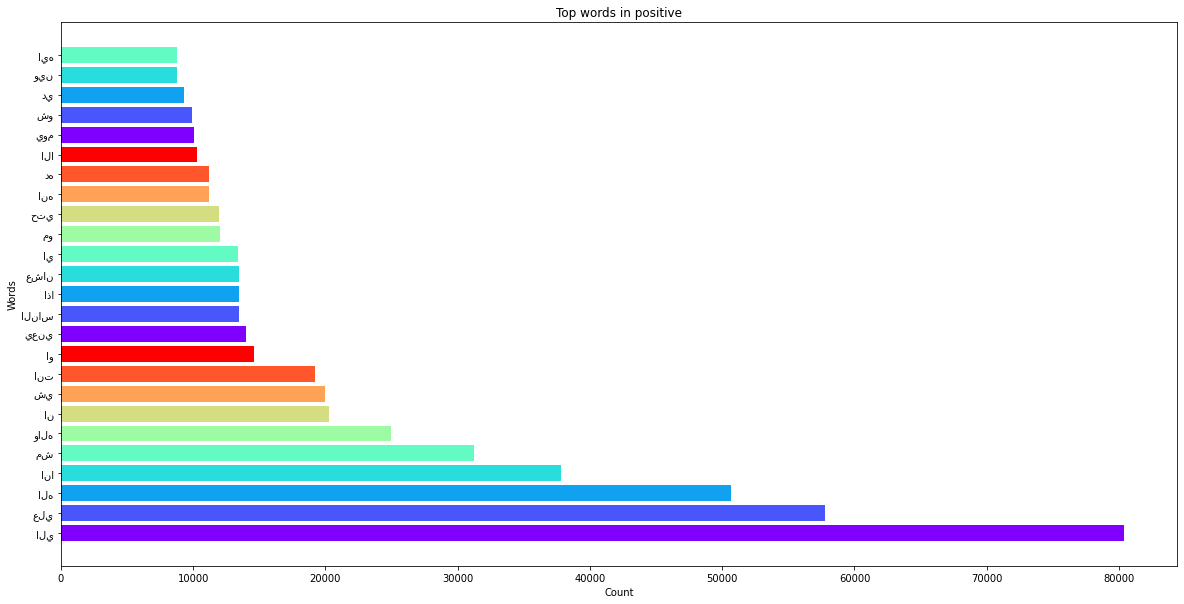

In [35]:
words = []
counts = []
for letter, count in counter.most_common(25):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.rcParams['figure.figsize'] = 20, 10

plt.title('Top words in positive')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

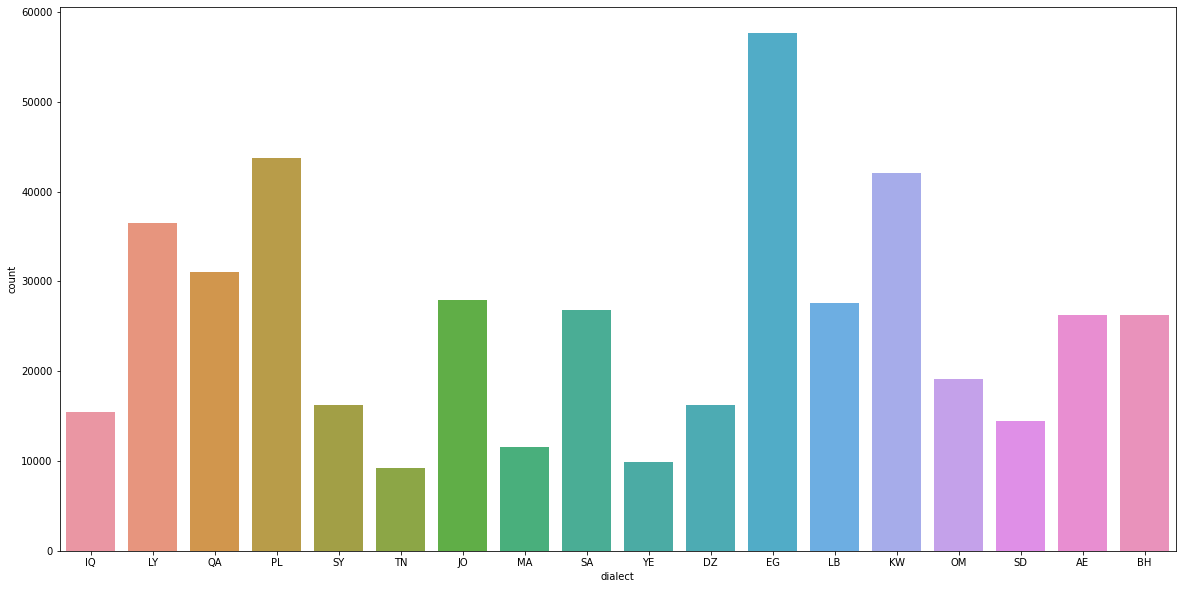

In [38]:
sns.countplot(data= df, x = "dialect")
plt.show()